In [1]:
import pandas as pd

# Load the dataset
file_path = 'bank_marketing_dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows and summary statistics of the dataset
data_head = data.head()
data_info = data.info()
data_description = data.describe()

data_head, data_info, data_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

(   age        job  marital    education  default housing loan    contact  \
 0   56  housemaid  married     basic.4y       no      no   no  telephone   
 1   57   services  married  high.school  unknown      no   no  telephone   
 2   37   services  married  high.school       no     yes   no  telephone   
 3   40     admin.  married     basic.6y       no      no   no  telephone   
 4   56   services  married  high.school       no      no  yes  telephone   
 
   month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
 0   may         mon  ...         1    999         0  nonexistent          1.1   
 1   may         mon  ...         1    999         0  nonexistent          1.1   
 2   may         mon  ...         1    999         0  nonexistent          1.1   
 3   may         mon  ...         1    999         0  nonexistent          1.1   
 4   may         mon  ...         1    999         0  nonexistent          1.1   
 
    cons.price.idx  cons.conf.idx  euribor

# Preprocessing

In [2]:
from sklearn.preprocessing import LabelEncoder

# Copying the dataset to avoid changes to the original dataframe
data_preprocessed = data.copy()

# Initialize LabelEncoder
le = LabelEncoder()

# Columns to encode
categorical_columns = data_preprocessed.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('subscribed')  # We'll handle the target variable separately

# Encoding categorical features
for column in categorical_columns:
    data_preprocessed[column] = data_preprocessed[column].replace('unknown', None)  # Replace 'unknown' with NaN
    data_preprocessed[column] = le.fit_transform(data_preprocessed[column].astype(str))  # Encode

# Encoding target variable
data_preprocessed['subscribed'] = le.fit_transform(data_preprocessed['subscribed'])

# Check the head of the dataframe and the handling of 'unknown' values
data_preprocessed.head(), data_preprocessed.isnull().sum()


(   age  job  marital  education  default  housing  loan  contact  month  \
 0   56    4        2          1        1        1     1        1      6   
 1   57    8        2          4        0        1     1        1      6   
 2   37    8        2          4        1        2     1        1      6   
 3   40    1        2          2        1        1     1        1      6   
 4   56    8        2          4        1        1     2        1      6   
 
    day_of_week  ...  campaign  pdays  previous  poutcome  emp.var.rate  \
 0            1  ...         1    999         0         1           1.1   
 1            1  ...         1    999         0         1           1.1   
 2            1  ...         1    999         0         1           1.1   
 3            1  ...         1    999         0         1           1.1   
 4            1  ...         1    999         0         1           1.1   
 
    cons.price.idx  cons.conf.idx  euribor3m  nr.employed  subscribed  
 0          93.994

In [3]:
# Checking the distribution of the target variable 'subscribed'
subscription_counts = data_preprocessed['subscribed'].value_counts(normalize=True)
subscription_counts


subscribed
0    0.887346
1    0.112654
Name: proportion, dtype: float64

In [4]:
# Dropping the specified columns: 'duration', 'poutcome', and 'day_of_week'
data_preprocessed = data_preprocessed.drop(['duration', 'poutcome', 'day_of_week'], axis=1)

# Display the updated DataFrame to confirm the changes
data_preprocessed.head()


,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,4,2,1,1,1,1,1,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,8,2,4,0,1,1,1,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,8,2,4,1,2,1,1,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,1,2,2,1,1,1,1,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,8,2,4,1,1,2,1,6,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Columns to scale (all numeric columns except the target variable)
numeric_columns = data_preprocessed.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [6]:
numeric_columns

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

# Upsampling

In [7]:
from sklearn.utils import resample

# Separate the majority and minority classes
data_majority = data_preprocessed[data_preprocessed.subscribed == 0]
data_minority = data_preprocessed[data_preprocessed.subscribed == 1]

# Upsample minority class
data_minority_upsampled = resample(data_minority,
                                   replace=True,     # sample with replacement
                                   n_samples=len(data_majority),    # to match majority class
                                   random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_balanced = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
data_balanced['subscribed'].value_counts()


subscribed
0    36548
1    36548
Name: count, dtype: int64

data_balanced=data_preprocessed.copy()

In [8]:
import pandas as pd
# Create a copy of the data_balanced dataset
dataset1 = data_balanced.copy()

# Print the first few rows of dataset1
print(dataset1.head())


   age  job  marital  education  default  housing  loan  contact  month  \
0   56    4        2          1        1        1     1        1      6   
1   57    8        2          4        0        1     1        1      6   
2   37    8        2          4        1        2     1        1      6   
3   40    1        2          2        1        1     1        1      6   
4   56    8        2          4        1        1     2        1      6   

   campaign  pdays  previous  emp.var.rate  cons.price.idx  cons.conf.idx  \
0         1    999         0           1.1          93.994          -36.4   
1         1    999         0           1.1          93.994          -36.4   
2         1    999         0           1.1          93.994          -36.4   
3         1    999         0           1.1          93.994          -36.4   
4         1    999         0           1.1          93.994          -36.4   

   euribor3m  nr.employed  subscribed  
0      4.857       5191.0           0  
1     

In [9]:
# Applying standard scaling
data_balanced[numeric_columns] = scaler.fit_transform(data_balanced[numeric_columns])

# Display the scaled dataframe to confirm the changes
data_balanced.head()

,age,job,marital,education,default,housing,loan,contact,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,1.305973,4,2,1,1,1,1,1,6,-0.56714,0.356658,-0.447954,0.924539,0.814609,0.71345,1.000075,0.636166,0
1,1.389478,8,2,4,0,1,1,1,6,-0.56714,0.356658,-0.447954,0.924539,0.814609,0.71345,1.000075,0.636166,0
2,-0.280637,8,2,4,1,2,1,1,6,-0.56714,0.356658,-0.447954,0.924539,0.814609,0.71345,1.000075,0.636166,0
3,-0.030120,1,2,2,1,1,1,1,6,-0.56714,0.356658,-0.447954,0.924539,0.814609,0.71345,1.000075,0.636166,0
4,1.305973,8,2,4,1,1,2,1,6,-0.56714,0.356658,-0.447954,0.924539,0.814609,0.71345,1.000075,0.636166,0


# Logistical Regression for Reference

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare features and target
X_balanced = data_balanced.drop('subscribed', axis=1)
y_balanced = data_balanced['subscribed']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Coefficients
coefficients = pd.DataFrame(log_reg.coef_.T, index=X_balanced.columns, columns=['Coefficient'])

coefficients


,Coefficient
age,0.022100
job,0.001677
marital,0.085864
education,0.019787
default,0.246737
housing,-0.004183
loan,0.025915
contact,-0.817695
month,-0.113911
campaign,-0.075320


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.7344049247606019
Precision: 0.7880129405755151
Recall: 0.6369391687310763
F1 Score: 0.704467615495852
Confusion Matrix:
 [[6109 1245]
 [2638 4628]]


# Causal Inference

In [13]:
import econml
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML
from econml.orf import DMLOrthoForest
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import LassoCV

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Effect of Campaign

In [14]:
W = data_balanced[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']]
T = dataset1[['campaign']]
Y = data_balanced['subscribed']
X = data_balanced[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']]

In [15]:
# First split: Separating out the test set
Y_train_val, Y_test, T_train_val, T_test, X_train_val, X_test, W_train_val, W_test = train_test_split(
    Y, T, X, W, test_size=0.2, random_state=123)

# Second split: Splitting the remaining data into training and validation sets
Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(
    Y_train_val, T_train_val, X_train_val, W_train_val, test_size=0.25, random_state=123) # 0.25 * 0.8 = 0.2

In [16]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
import shap

### Casual Forest

In [23]:
import mlflow
from mlflow.tracking import MlflowClient
import numpy as np
from econml.dml import CausalForestDML
from xgboost import XGBRegressor

mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = "Campaign_Causal_Forest_Experiment"
client = MlflowClient()
experiment = client.get_experiment_by_name(experiment_name)

if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(experiment_id=experiment_id):
    mlflow.log_param("model_type", "CausalForestDML")
    mlflow.log_param("model_y", "XGBRegressor")
    mlflow.log_param("model_y_seed", 42)
    mlflow.log_param("model_t", "XGBRegressor")
    mlflow.log_param("model_t_seed", 42)
    mlflow.log_param("criterion", "mse")
    mlflow.log_param("n_estimators", 1000)
    mlflow.log_param("min_impurity_decrease", 0.0001)
    mlflow.log_param("random_state", 123)
    
    est = CausalForestDML(
        model_y=XGBRegressor(objective='reg:squarederror', seed=42),
        model_t=XGBRegressor(objective='reg:squarederror', seed=42),
        criterion='mse', n_estimators=1000,
        min_impurity_decrease=0.0001,
        random_state=123
    )
    est.fit(Y_train, T_train, X=X_train, W=W_train)
    
    te_pred = est.effect(X_test)
    
    lower_bound = np.percentile(te_pred, 2.5)
    upper_bound = np.percentile(te_pred, 97.5)
    
    avg_effect = est.ate(X)


    mlflow.log_metric("average_treatment_effect", avg_effect)
    mlflow.log_metric("lower_bound_95_CI", lower_bound)
    mlflow.log_metric("upper_bound_95_CI", upper_bound)
    
    print(f"Mean effect of treatment: {avg_effect}")
    print(f"Effect Interval (95% confidence): [{lower_bound}, {upper_bound}]")

    mlflow.sklearn.log_model(est, "causal_forest_model", registered_model_name="causal_forest_model")
    mlflow.end_run()


Mean effect of treatment: -0.009241466081515031
Effect Interval (95% confidence): [-0.026140881004831827, 0.0005314116355838516]


2024/05/03 00:43:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'causal_forest_model' already exists. Creating a new version of this model...
2024/05/03 00:43:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: causal_forest_model, version 3
Created version '3' of model 'causal_forest_model'.


### Linear DML

In [24]:
import mlflow
from econml.dml import LinearDML
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = "Campaign_Linear_DML_Experiment"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_params({
        "model_type": "LinearDML",
        "model_y": "XGBRegressor",
        "model_y_seed": 42,
        "model_t": "XGBRegressor",
        "model_t_seed": 42,
        "random_state": 123
    })

    est2 = LinearDML(
        model_y=XGBRegressor(objective='reg:squarederror', seed=42),
        model_t=XGBRegressor(objective='reg:squarederror', seed=42),
        random_state=123
    )
    

    est2.fit(Y_train, T_train, X=X_train, W=W_train)
    
    te_pred2 = est2.effect(X_test)

    lower_bound2 = np.percentile(te_pred2, 2.5)
    upper_bound2 = np.percentile(te_pred2, 97.5)
    
    avg_effect2 = est2.ate(X)
    
    mlflow.log_metrics({
        "average_treatment_effect": avg_effect2,
        "lower_bound_95_CI": lower_bound2,
        "upper_bound_95_CI": upper_bound2
    })
    
    print(f"Mean effect of treatment: {avg_effect2}")
    print(f"Effect Interval (95% confidence): [{lower_bound2}, {upper_bound2}]")

    mlflow.sklearn.log_model(est2, "linear_dml_model", registered_model_name="linear_dml_model")
    mlflow.end_run()

2024/05/03 00:43:57 INFO mlflow.tracking.fluent: Experiment with name 'Campaign_Linear_DML_Experiment' does not exist. Creating a new experiment.


2024/05/03 00:43:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Mean effect of treatment: -0.01135688211468841
Effect Interval (95% confidence): [-0.03639147084816514, 0.008897183497642394]


Registered model 'linear_dml_model' already exists. Creating a new version of this model...
2024/05/03 00:44:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: linear_dml_model, version 2
Created version '2' of model 'linear_dml_model'.


In [66]:
shap_values = est2.shap_values(X)

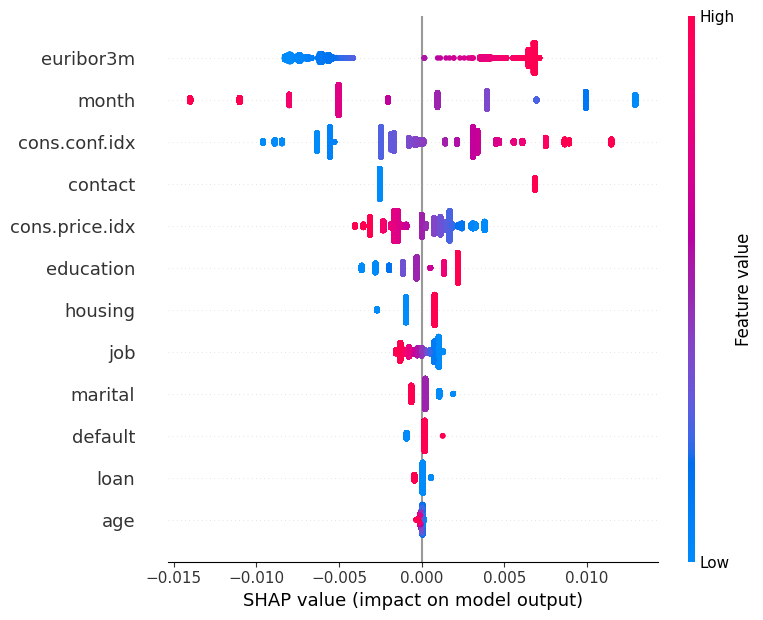

In [67]:
# convert dict_keys object to a list to make it subscriptable
output_name = list(shap_values.keys())[0] 
treatment_name = list(shap_values[output_name].keys())[0] 

specific_shap_values = shap_values[output_name][treatment_name]


# visualize the SHAP values
shap.summary_plot(specific_shap_values, X)

### Effect of Euribor

In [28]:
W = data_balanced[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'cons.price.idx', 'cons.conf.idx','campaign']]
T = dataset1[['euribor3m']]
Y = data_balanced['subscribed']
X = data_balanced[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'cons.price.idx', 'cons.conf.idx','campaign']]

In [29]:
# First split: Separating out the test set
Y_train_val, Y_test, T_train_val, T_test, X_train_val, X_test, W_train_val, W_test = train_test_split(
    Y, T, X, W, test_size=0.2, random_state=123)

# Second split: Splitting the remaining data into training and validation sets
Y_train, Y_val, T_train, T_val, X_train, X_val, W_train, W_val = train_test_split(
    Y_train_val, T_train_val, X_train_val, W_train_val, test_size=0.25, random_state=123) # 0.25 * 0.8 = 0.2

### Casual Forest

In [30]:
import mlflow
from econml.dml import LinearDML
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = "Euribor_Causal_Forest_Experiment"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_params({
        "model_type": "CausalForestDML",
        "model_y": "XGBRegressor",
        "model_y_seed": 42,
        "model_t": "XGBRegressor",
        "model_t_seed": 42,
        "random_state": 123,
        "min_impurity_decrease": 0.0005,
        "n_estimators": 1000,
        "criterion": "mse"   
    })
    


    est = CausalForestDML(model_y=XGBRegressor(objective='reg:squarederror', seed=42),
                        model_t=XGBRegressor(objective='reg:squarederror', seed=42),
                        criterion='mse', n_estimators=1000,
                        min_impurity_decrease=0.0005,
                        random_state=123)
    est.fit(Y_train, T_train, X=X_train, W=W_train)
    te_pred = est.effect(X_test)
    

    # Calculate the confidence interval using percentiles
    lower_bound = np.percentile(te_pred, 2.5)
    upper_bound = np.percentile(te_pred, 97.5)
    avg_effect = est.ate(X)

    mlflow.log_metrics({
        "average_treatment_effect": avg_effect,
        "lower_bound_95_CI": lower_bound,
        "upper_bound_95_CI": upper_bound
    })
    
    print(f"Mean effect of treatment:{avg_effect}")
    print("Effect Interval (95% confidence): [{}, {}]".format(lower_bound, upper_bound))


    mlflow.sklearn.log_model(est, "CausalForestDML", registered_model_name="CausalForestDML")
    mlflow.end_run()

Mean effect of treatment:-0.10922887674412755
Effect Interval (95% confidence): [-0.3703344134277583, -0.030699659134896196]


2024/05/03 00:50:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'CausalForestDML' already exists. Creating a new version of this model...
2024/05/03 00:50:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: CausalForestDML, version 3
Created version '3' of model 'CausalForestDML'.


### Linear DML

In [31]:
import mlflow
from econml.dml import LinearDML
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error

mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_name = "Eurbior_Linear_DML_Experiment"
mlflow.set_experiment(experiment_name)

with mlflow.start_run():
    mlflow.log_params({
        "model_type": "LinearDML",
        "model_y": "Lasso",
        "model_t": "Lasso",
        "random_state": 123
    })
    
    est2 = LinearDML(model_y=Lasso(),
                    model_t=Lasso(),
                    random_state=123)
    est2.fit(Y_train, T_train, X=X_train, W=W_train)
    te_pred2 = est2.effect(X_test)

    est2.fit(Y_train, T_train, X=X_train, W=W_train)
    
    te_pred2 = est2.effect(X_test)

    # Calculate the confidence interval using percentiles
    lower_bound2 = np.percentile(te_pred2, 2.5)
    upper_bound2 = np.percentile(te_pred2, 97.5)
    avg_effect2 = est2.ate(X)
    # Print effect
    print(f"Mean effect of treatment:{avg_effect2}")
    print("Effect Interval (95% confidence): [{}, {}]".format(lower_bound2, upper_bound2))
    
    mlflow.log_metrics({
        "average_treatment_effect": avg_effect2,
        "lower_bound_95_CI": lower_bound2,
        "upper_bound_95_CI": upper_bound2
    })

    mlflow.sklearn.log_model(est2, "linear_dml_model", registered_model_name="linear_dml_model")
    mlflow.end_run()

2024/05/03 00:52:10 INFO mlflow.tracking.fluent: Experiment with name 'Eurbior_Linear_DML_Experiment' does not exist. Creating a new experiment.
2024/05/03 00:52:10 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Mean effect of treatment:-0.11105254221583588
Effect Interval (95% confidence): [-0.18311508062714998, -0.015680850961249937]


Registered model 'linear_dml_model' already exists. Creating a new version of this model...
2024/05/03 00:52:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: linear_dml_model, version 3
Created version '3' of model 'linear_dml_model'.


In [82]:
shap_values = est2.shap_values(X)

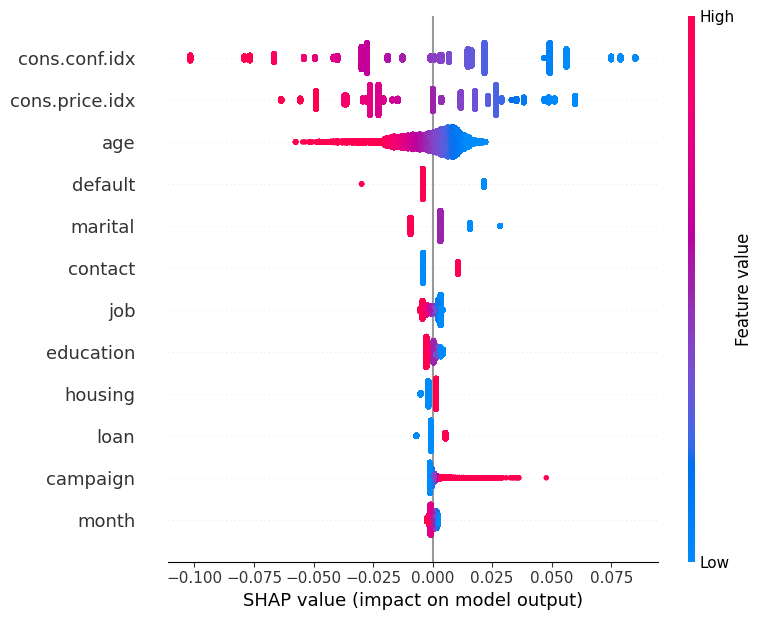

In [83]:
# convert dict_keys object to a list to make it subscriptable
output_name = list(shap_values.keys())[0] 
treatment_name = list(shap_values[output_name].keys())[0] 

specific_shap_values = shap_values[output_name][treatment_name]


# visualize the SHAP values
shap.summary_plot(specific_shap_values, X)